### ライブラリ

In [70]:
import matplotlib.pyplot as plt
from sklearn import datasets

import torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms

### Learning Rate Finder

In [67]:
def learning_rate_finder(model, train_loader, los_func, lr_multiplier=1.2):

    lr = 1e-5
    max_lr = 10
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    losses = []
    lrs = []

    for train_batch, data in enumerate(train_loader):

        # get data
        X, y = data
        opt.zero_grad()

        # forward
        preds = model(X)

        # calculate loss
        loss = los_func(preds, y)
        losses.append(loss.item())

        # backward
        loss.backward()
        opt.step()

        # increase learning rate
        lrs.append(lr)
        lr *= lr_multiplier
        for param_group in opt.param_groups:
            param_group['lr'] = lr
        if lr > max_lr:
            break

    return lrs, losses

In [68]:
# 前処理
transform = transforms.Compose([
    # 画像をテンソルに変換
    transforms.ToTensor(),
    # 画像のピクセル値を-1~1に正規化
    transforms.Normalize((0.5,), (0.5,))
])

# データセットのダウンロード
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# データローダーの作成
batch_size = 10
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# アーキテクチャの定義
class MLP(nn.Module):
    def __init__(self, num_in, num_hidden, num_out):
        super().__init__()
        self.flatten = nn.Flatten()                 # [batch_size, channel, height, width] -> [batch_size, channel * height * width]
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_out)

    def forward(self, x):
        x = self.flatten(x)
        z1 = self.l1(x)
        a1 = F.relu(z1)
        x = self.l2(a1)
        return x

# モデルのインスタンス化
model = MLP(28*28, 30, 10)

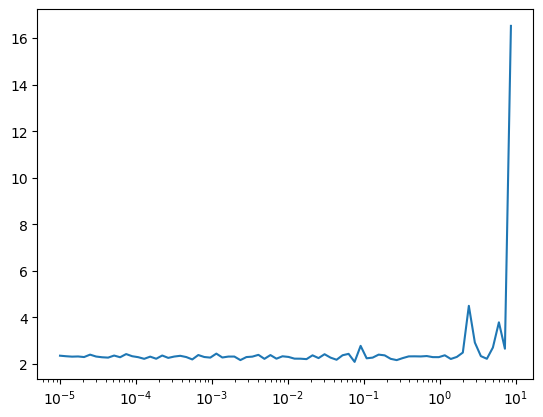

In [69]:
# 学習率の探索結果
lrs, losses = learning_rate_finder(model, train_loader, F.cross_entropy, lr_multiplier=1.2)
plt.plot(lrs, losses)
plt.xscale('log')

### Learning Rate Scheduler

In [ ]:
model = MLP(28*28, 30, 10)
opt = optim.SGD(model.parameters(), lr=1e-2)
# StepLR
scheduler = StepLR(opt, step_size=30, gamma=0.1)